In [2]:
 pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import KFold, cross_val_score,train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix

In [124]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = nltk.corpus.stopwords.words("english")

In [242]:
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics.pairwise import cosine_similarity

## 0-simpple tokenizers, readibility 

In [134]:
from nltk.tokenize import word_tokenize,sent_tokenize

In [59]:
documents = ['Have you seen this book?',
             'I need to do my homeworks ',
            'consider it done!',
            'this book is amazing. Have you read it?',
            'I am considering your book by today',
            'this is very bad sentences. we try to make it negative',
            'this is supposed to show very admiring sentences. adorable']
documents

['Have you seen this book?',
 'I need to do my homeworks ',
 'consider it done!',
 'this book is amazing. Have you read it?',
 'I am considering your book by today',
 'this is very bad sentences. we try to make it negative',
 'this is supposed to show very admiring sentences. adorable']

In [131]:
# Split text into words using NLTK
from nltk.tokenize import word_tokenize
[word_tokenize (x) for x in documents]

[['Have', 'you', 'seen', 'this', 'book', '?'],
 ['I', 'need', 'to', 'do', 'my', 'homeworks'],
 ['consider', 'it', 'done', '!'],
 ['this', 'book', 'is', 'amazing', '.', 'Have', 'you', 'read', 'it', '?'],
 ['I', 'am', 'considering', 'your', 'book', 'by', 'today'],
 ['this',
  'is',
  'very',
  'bad',
  'sentences',
  '.',
  'we',
  'try',
  'to',
  'make',
  'it',
  'negative'],
 ['accept',
  'acclaim',
  'acomplish',
  'to',
  'show',
  'very',
  'admiring',
  'sentences',
  '.',
  'adorable']]

In [132]:
def word_tokenize(sent):
    return [ w for w in word_tokenizer.tokenize(sent) if w.isalpha() ]

In [133]:
[word_tokenize (x) for x in documents]

[['Have', 'you', 'seen', 'this', 'book'],
 ['I', 'need', 'to', 'do', 'my', 'homeworks'],
 ['consider', 'it', 'done'],
 ['this', 'book', 'is', 'amazing', 'Have', 'you', 'read', 'it'],
 ['I', 'am', 'considering', 'your', 'book', 'by', 'today'],
 ['this',
  'is',
  'very',
  'bad',
  'sentences',
  'we',
  'try',
  'to',
  'make',
  'it',
  'negative'],
 ['accept',
  'acclaim',
  'acomplish',
  'to',
  'show',
  'very',
  'admiring',
  'sentences',
  'adorable']]

In [74]:
# Split text into sentences
[sent_tokenize (x) for x in documents]# , wont split the sentence

[['Have you seen this book?'],
 ['I need to do my homeworks'],
 ['consider it done!'],
 ['this book is amazing.', 'Have you read it?'],
 ['I am considering your book by today']]

####  readability

In [135]:
from nltk.corpus import cmudict
import numpy as np
d = cmudict.dict()

def syllable_count(word):
    try:
        return np.min([len(list(y for y in x if y[-1].isdigit())) for x in d[word.lower()]])
    except KeyError:
        #if word not found in cmudict
        return _syllables(word)

def _syllables(word):
#referred from stackoverflow.com/questions/14541303/count-the-number-of-syllables-in-a-word
    count = 0
    vowels = 'aeiouy'
    word = word.lower()
    if word[0] in vowels:
        count +=1
    for index in range(1,len(word)):
        if word[index] in vowels and word[index-1] not in vowels:
            count +=1
    if word.endswith('e'):
        count -= 1
    if word.endswith('le'):
        count+=1
    if count == 0:
        count +=1
    return count

def sentence_count(text):
    return len(sent_tokenize.tokenize(text))

def word_count(sent):
    return len([ w for w in word_tokenize(sent)])

def hard_word_count(sent):
    return len([ w for w in word_tokenize(sent) \
                 if syllable_count(lemmatizer.lemmatize(w, pos='v'))>=3 ])
def flesch_index(text):
    sentences = sent_tokenize(text)

    total_sentences = len(sentences)
    total_words = np.sum([ word_count(s) for s in sentences ])
    total_syllables = np.sum([ np.sum([ syllable_count(w) for w in word_tokenize(s) ]) \
                               for s in sentences ])

    return 0.39*(total_words/total_sentences) + \
           11.8*(total_syllables/total_words) - 15.59

def fog_index(text):
    sentences = sent_tokenize(text)

    total_sentences = len(sentences)
    total_words = np.sum([ word_count(s) for s in sentences ])
    total_hard_words = np.sum([ hard_word_count(s) for s in sentences ])

    return 0.4*((total_words/total_sentences) + \
                100.0*(total_hard_words/total_words))

In [136]:
[hard_word_count(c) for c in documents]

[0, 1, 1, 0, 1, 1, 2]

In [137]:
[flesch_index(c) for c in documents]

[-1.4499999999999993,
 2.4833333333333343,
 3.6700000000000017,
 0.5199999999999996,
 5.682857142857145,
 3.4666666666666686,
 12.320000000000004]

In [138]:
[fog_index(c) for c in documents]

[2.4000000000000004,
 9.066666666666666,
 11.600000000000001,
 2.0,
 8.514285714285714,
 5.733333333333333,
 10.0]

## 1- Original tokenizer

In [52]:
def tokenize(text):
    '''this method does the following
    1. normalizing all the words to lower size
    2. removes punctuations
    3. splits the words
    4. removes the stopwords like am,is,have,you,...
    5. lammetizes the words for example running-->run
    '''
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())    # normalize case and remove punctuation
    tokens = word_tokenize(text)    # tokenize text
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]    # lemmatize andremove stop words
    return tokens


In [40]:
[tokenize (x) for x in documents]

[['see', 'book'],
 ['need', 'homework'],
 ['consider', 'do'],
 ['book', 'amaze', 'read'],
 ['consider', 'book', 'today'],
 ['bad', 'sentence', 'try', 'make', 'negative'],
 ['suppose', 'show', 'positive', 'sentence', 'almost', 'best']]

## 2- Port Stemmer

In [41]:
from nltk.stem.porter import PorterStemmer
def tokenize(text):
    '''this method does the following
    1. normalizing all the words to lower size
    2. removes punctuations
    3. splits the words
    4. removes the stopwords like am,is,have,you,...
    5. lammetizes the words for example running-->run
    6. this does better since it lemmetize for verbs too
    '''
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())    # normalize case and remove punctuation
    tokens = word_tokenize(text)    # tokenize text
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]    # lemmatize andremove stop words
#     tokens = [lemmatizer.lemmatize(word,pos='v') for word in tokens if word not in stop_words]    # lemmatize andremove stop words
    tokens = [PorterStemmer().stem(word) for word in tokens if word not in stop_words]    # lemmatize andremove stop words
    return tokens

In [42]:
[tokenize (x) for x in documents]

[['seen', 'book'],
 ['need', 'homework'],
 ['consid', 'done'],
 ['book', 'amaz', 'read'],
 ['consid', 'book', 'today'],
 ['bad', 'sentenc', 'tri', 'make', 'neg'],
 ['suppos', 'show', 'posit', 'sentenc', 'almost', 'best']]

## 3-  Snowball stemmer

In [43]:
from nltk.stem import SnowballStemmer

In [44]:
def tokenize(text):
    '''this method does the following
    1. normalizing all the words to lower size
    2. removes punctuations
    3. splits the words
    4. removes the stopwords like am,is,have,you,...
    5. lammetizes the words for example running-->run
    6. this does better since it lemmetize for verbs too
    '''
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())    # normalize case and remove punctuation
    tokens = word_tokenize(text)    # tokenize text
#     tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]    # lemmatize andremove stop words
    tokens = [SnowballStemmer('english').stem(word) for word in tokens if word not in stop_words]    # lemmatize andremove stop words
    return tokens

In [45]:
[tokenize (x) for x in documents]

[['seen', 'book'],
 ['need', 'homework'],
 ['consid', 'done'],
 ['book', 'amaz', 'read'],
 ['consid', 'book', 'today'],
 ['bad', 'sentenc', 'tri', 'make', 'negat'],
 ['suppos', 'show', 'posit', 'sentenc', 'almost', 'best']]

## 3. Lemmetizer with verbs

In [46]:
def tokenize(text):
    '''this method does the following
    1. normalizing all the words to lower size
    2. removes punctuations
    3. splits the words
    4. removes the stopwords like am,is,have,you,...
    5. lammetizes the words for example running-->run
    6. this does better since it lemmetize for verbs too
    '''
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())    # normalize case and remove punctuation
    tokens = word_tokenize(text)    # tokenize text
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]    # lemmatize andremove stop words
    tokens = [lemmatizer.lemmatize(word,pos='v') for word in tokens if word not in stop_words]    # lemmatize andremove stop words
#     tokens = [PorterStemmer().stem(word) for word in tokens if word not in stop_words]    # lemmatize andremove stop words
    return tokens

In [47]:
[tokenize (x) for x in documents]

[['see', 'book'],
 ['need', 'homework'],
 ['consider', 'do'],
 ['book', 'amaze', 'read'],
 ['consider', 'book', 'today'],
 ['bad', 'sentence', 'try', 'make', 'negative'],
 ['suppose', 'show', 'positive', 'sentence', 'almost', 'best']]

## 4- another nice version

In [48]:
from nltk.tokenize import RegexpTokenizer
wnl = WordNetLemmatizer()
sno = SnowballStemmer('english')
# tokenize anything that is not a number and not a symbol
word_tokenizer = RegexpTokenizer(r'[^\d\W]+')
def clean_text(txt):
    lemm_txt = [ wnl.lemmatize(wnl.lemmatize(w.lower(),'n'),'v') \
                 for w in word_tokenizer.tokenize(txt) if \
                 w.isalpha() and w not in stop_words ]
    return [ sno.stem(w) for w in lemm_txt if w not in stop_words and len(w) > 2 ]

In [49]:
[clean_text (x) for x in documents]

[['see', 'book'],
 ['need', 'homework'],
 ['consid'],
 ['book', 'amaz', 'read'],
 ['consid', 'book', 'today'],
 ['bad', 'sentenc', 'tri', 'make', 'negat'],
 ['suppos', 'show', 'posit', 'sentenc', 'almost', 'best']]

## 5- Bag of Words

In [50]:
def prep_data(text,method=CountVectorizer):
    '''
    this method counts either counts the words 
    in sentences (CountVectorizer) or wights them 
    based on their importance in the sentence 
    and entire data(TfidfVectorizer):
    '''
    count_vector = method(tokenizer=tokenize)
    count_vector.fit(text)
    doc_array = count_vector.transform(text).toarray()
    frequency_matrix_count = pd.DataFrame(doc_array, columns=count_vector.get_feature_names())
    return frequency_matrix_count,frequency_matrix_count.values,count_vector



In [51]:
df,vectorized,vectorizer=prep_data(documents)#uses countvectorizer
df

,almost,amaze,bad,best,book,consider,do,homework,make,need,negative,positive,read,see,sentence,show,suppose,today,try
0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0
5,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1
6,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0


## 6-Tf-idf 

In [52]:
df,vectorized,vectorizer=prep_data(documents,method=TfidfVectorizer)#uses TfidfVectorizer
df

,almost,amaze,bad,best,book,consider,do,homework,make,need,negative,positive,read,see,sentence,show,suppose,today,try
0,0.000000,0.000000,0.000000,0.000000,0.578667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.815564,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.707107,0.000000,0.707107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.638709,0.769449,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.632022,0.000000,0.000000,0.448438,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.632022,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.479185,0.560603,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.675356,0.000000
5,0.000000,0.000000,0.461804,0.000000,0.000000,0.000000,0.000000,0.000000,0.461804,0.000000,0.461804,0.000000,0.000000,0.000000,0.383337,0.000000,0.000000,0.000000,0.461804
6,0.419257,0.000000,0.000000,0.419257,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.419257,0.000000,0.000000,0.348019,0.419257,0.419257,0.000000,0.000000


## 7-Sentiment Analysiz

In [35]:
import pickle
with open('quises/49-basic NLP Analysis/positive_words.pickle', 'rb') as f:
    positive_words = pickle.load(f)
    # also need to stem and lemmatize the text
    positive_words = set(clean_text(" ".join(positive_words)))

with open('quises/49-basic NLP Analysis/negative_words.pickle', 'rb') as f:
    negative_words = pickle.load(f)
    negative_words = set(clean_text(" ".join(negative_words)))

In [245]:
documents = ['Have you seen this book? adorable',
             'I need to do my homeworks ',
            'consider it done! accomplish',
            'this book is amazing. Have you read it?',
            'I am considering your book by today',
            'this is accept very bad sentences. we try to make it negative',
            'accept accept acclaim acomplish to show very admiring sentences. adorable']
documents

['Have you seen this book? adorable',
 'I need to do my homeworks ',
 'consider it done! accomplish',
 'this book is amazing. Have you read it?',
 'I am considering your book by today',
 'this is accept very bad sentences. we try to make it negative',
 'accept accept acclaim acomplish to show very admiring sentences. adorable']

In [246]:
def get_sentiment(txt, wordlist):
    matching_words = [ w for w in tokenize(txt) if w in wordlist ]
    return len(matching_words)/len(txt)

In [247]:
def get_sentiment(txt, wordlist):
    matching_words = [ w for w in clean_text(txt) if w in wordlist ]
    return len(matching_words)/len(txt)

In [248]:
tokenize(documents[6])

['accept',
 'accept',
 'acclaim',
 'acomplish',
 'show',
 'admire',
 'sentence',
 'adorable']

In [249]:
[ w for w in tokenize(documents[6]) if w in positive_words ]

['accept', 'accept', 'acclaim']

In [250]:
[ w for w in clean_text(documents[6]) if w in positive_words ]

['accept', 'accept', 'acclaim', 'admir', 'ador']

In [251]:
positive_sentiments = np.array([ get_sentiment(c, positive_words) for c in documents ])
pd.DataFrame(positive_sentiments)

negative_sentiments = np.array([ get_sentiment(c, negative_words) for c in documents ])
pd.DataFrame(negative_sentiments)

,0
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.016393
6,0.000000


### counting the positve words

In [252]:
def get_bag_of_words(sentiment_words, docs):
    """
    Generate a bag of words from documents for a certain sentiment
    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words
    Returns
    -------
    bag_of_words : 2-d Numpy Ndarray of int
        Bag of words sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    cnt_vec = CountVectorizer(vocabulary=sentiment_words)
    bag_of_words = cnt_vec.fit_transform(docs).toarray()
    return bag_of_words

In [253]:
documents[0:2]

['Have you seen this book? adorable', 'I need to do my homeworks ']

In [254]:
len(positive_words)

215

In [255]:
documents

['Have you seen this book? adorable',
 'I need to do my homeworks ',
 'consider it done! accomplish',
 'this book is amazing. Have you read it?',
 'I am considering your book by today',
 'this is accept very bad sentences. we try to make it negative',
 'accept accept acclaim acomplish to show very admiring sentences. adorable']

In [256]:
bow=get_bag_of_words(positive_words, documents)
pd.DataFrame(bow,columns=sorted(positive_words))

,abund,accept,acclaim,accomplish,achiev,actual,admir,ador,adorn,advanc,...,victori,virtuous,visionari,wealth,wealthi,wholesom,win,winner,wonder,wow
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 8- Jaccard Similarity 

### Jaccard Similarity 

In [257]:
def get_jaccard_similarity(bag_of_words_matrix):
    """
    Get jaccard similarities for neighboring documents
    Parameters
    ----------
    bag_of_words : 2-d Numpy Ndarray of int
        Bag of words sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    Returns
    -------
    jaccard_similarities : list of float
        Jaccard similarities for neighboring documents
    """
    bows = bag_of_words_matrix.astype(bool)    
    score = [jaccard_similarity_score(c, n) for c, n in zip(bows, bows[1:])]        
    return score

In [258]:
get_jaccard_similarity(bow)

[1.0,
 0.9953488372093023,
 0.9953488372093023,
 1.0,
 0.9953488372093023,
 0.9953488372093023]

In [259]:
bow[1:]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 2, 1, ..., 0, 0, 0]], dtype=int64)

## 9- Tf-idf

In [260]:
from collections import defaultdict
def get_idf(corpus, include_log=True):
    N = len(corpus)
    freq = defaultdict(int)
    words = set()
    for c in corpus:
        words |= set(c)

    for w in words:
        freq[w] = sum([ w in c for c in corpus])

    if include_log:
        return { w:np.log(N/freq[w]) for w in freq }
    else:
        return { w:N/freq[w] for w in freq }

In [261]:
[tokenize (x) for x in documents]

[['see', 'book', 'adorable'],
 ['need', 'homework'],
 ['consider', 'do', 'accomplish'],
 ['book', 'amaze', 'read'],
 ['consider', 'book', 'today'],
 ['accept', 'bad', 'sentence', 'try', 'make', 'negative'],
 ['accept',
  'accept',
  'acclaim',
  'acomplish',
  'show',
  'admire',
  'sentence',
  'adorable']]

In [262]:
idf=get_idf([tokenize (x) for x in documents])
idf         

{'accomplish': 1.9459101490553132,
 'today': 1.9459101490553132,
 'show': 1.9459101490553132,
 'consider': 1.252762968495368,
 'sentence': 1.252762968495368,
 'do': 1.9459101490553132,
 'accept': 1.252762968495368,
 'try': 1.9459101490553132,
 'acclaim': 1.9459101490553132,
 'adorable': 1.252762968495368,
 'need': 1.9459101490553132,
 'bad': 1.9459101490553132,
 'see': 1.9459101490553132,
 'make': 1.9459101490553132,
 'amaze': 1.9459101490553132,
 'acomplish': 1.9459101490553132,
 'book': 0.8472978603872037,
 'admire': 1.9459101490553132,
 'read': 1.9459101490553132,
 'negative': 1.9459101490553132,
 'homework': 1.9459101490553132}

In [263]:
import numpy as np
from math import *
def _tf(freq, avg, include_log=True):
    if include_log:
        return 0 if freq == 0 else (1+np.log(freq))/(1+np.log(avg))
    else:
        return freq/avg
def bag_of_words(words):
    bag = defaultdict(int)
    for w in words:
        bag[w] += 1
    return bag

def get_tf(txt, include_log=True):
    freq = bag_of_words(txt)
    avg = np.mean(list(freq.values()))
    tf = {w:_tf(f,avg, include_log) for w,f in freq.items()}
    return defaultdict(int, tf)


In [264]:
tfs=[ get_tf(c) for c in [tokenize(d) for d in documents] ]


In [265]:
def get_vector(tf, idf):
    return np.array([ tf[w]*idf[w] for w in idf ])

In [266]:
doc_vectors = [ get_vector(tf, idf) for tf in tfs ]

In [267]:
pd.DataFrame(doc_vectors)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,1.252763,...,0.00000,1.94591,0.00000,0.00000,0.00000,0.847298,0.00000,0.00000,0.00000,0.00000
1,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,1.94591
2,1.94591,0.00000,0.00000,1.252763,0.000000,1.94591,0.000000,0.00000,0.00000,0.000000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000
3,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,...,0.00000,0.00000,0.00000,1.94591,0.00000,0.847298,0.00000,1.94591,0.00000,0.00000
4,0.00000,1.94591,0.00000,1.252763,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.847298,0.00000,0.00000,0.00000,0.00000
5,0.00000,0.00000,0.00000,0.000000,1.252763,0.00000,1.252763,1.94591,0.00000,0.000000,...,1.94591,0.00000,1.94591,0.00000,0.00000,0.000000,0.00000,0.00000,1.94591,0.00000
6,0.00000,0.00000,1.71668,0.000000,1.105186,0.00000,1.871242,0.00000,1.71668,1.105186,...,0.00000,0.00000,0.00000,0.00000,1.71668,0.000000,1.71668,0.00000,0.00000,0.00000


### old method

In [268]:
df,vectorized,vectorizer=prep_data(documents,method=TfidfVectorizer)#uses TfidfVectorizer
df

,accept,acclaim,accomplish,acomplish,admire,adorable,amaze,bad,book,consider,...,homework,make,need,negative,read,see,sentence,show,today,try
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.560603,0.000000,0.000000,0.479185,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.675356,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.707107,0.000000,0.707107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.609819,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.506202,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.632022,0.000000,0.448438,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.632022,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.479185,0.560603,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.675356,0.000000
5,0.357939,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.431207,0.000000,0.000000,...,0.000000,0.431207,0.000000,0.431207,0.000000,0.000000,0.357939,0.000000,0.000000,0.431207
6,0.582095,0.350624,0.000000,0.350624,0.350624,0.291048,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.291048,0.350624,0.000000,0.000000


### counting positive words

In [269]:
def get_tfidf(sentiment_words, docs):
    """
    Generate TFIDF values from documents for a certain sentiment
    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words
    Returns
    -------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    # TODO: Implement
    vectorizer = TfidfVectorizer(vocabulary=sentiment_words)
    X = vectorizer.fit_transform(docs)    
    return X.toarray()

In [270]:
pd.DataFrame(get_tfidf(positive_words, documents),columns=sorted(positive_words))

,abund,accept,acclaim,accomplish,achiev,actual,admir,ador,adorn,advanc,...,victori,virtuous,visionari,wealth,wealthi,wholesom,win,winner,wonder,wow
0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.856605,0.515973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Cos similarity

In [279]:
cosine_similarity([[1,2,3]],[[-1,-2,-3]])

array([[-1.]])

### 46- Applying Regex_10k

In [47]:
import requests
import re
import pandas as pd

In [48]:
r = requests.get('https://www.sec.gov/Archives/edgar/data/320193/000032019318000145/0000320193-18-000145.txt')
raw_10k = r.text
print(raw_10k[0:2000])

<SEC-DOCUMENT>0000320193-18-000145.txt : 20181105
<SEC-HEADER>0000320193-18-000145.hdr.sgml : 20181105
<ACCEPTANCE-DATETIME>20181105080140
ACCESSION NUMBER:		0000320193-18-000145
CONFORMED SUBMISSION TYPE:	10-K
PUBLIC DOCUMENT COUNT:		88
CONFORMED PERIOD OF REPORT:	20180929
FILED AS OF DATE:		20181105
DATE AS OF CHANGE:		20181105

FILER:

	COMPANY DATA:	
		COMPANY CONFORMED NAME:			APPLE INC
		CENTRAL INDEX KEY:			0000320193
		STANDARD INDUSTRIAL CLASSIFICATION:	ELECTRONIC COMPUTERS [3571]
		IRS NUMBER:				942404110
		STATE OF INCORPORATION:			CA
		FISCAL YEAR END:			0930

	FILING VALUES:
		FORM TYPE:		10-K
		SEC ACT:		1934 Act
		SEC FILE NUMBER:	001-36743
		FILM NUMBER:		181158788

	BUSINESS ADDRESS:	
		STREET 1:		ONE APPLE PARK WAY
		CITY:			CUPERTINO
		STATE:			CA
		ZIP:			95014
		BUSINESS PHONE:		(408) 996-1010

	MAIL ADDRESS:	
		STREET 1:		ONE APPLE PARK WAY
		CITY:			CUPERTINO
		STATE:			CA
		ZIP:			95014

	FORMER COMPANY:	
		FORMER CONFORMED NAME:	APPLE COMPUTER INC
		DATE OF NA

In [49]:
# Write regexes
#A regex to find the <DOCUMENT> tag
#A regex to find the </DOCUMENT> tag
#A regex to find all the sections marked by the <Type> tag

doc_start_pattern = re.compile(r'<DOCUMENT>')
doc_end_pattern = re.compile(r'</DOCUMENT>')
type_pattern = re.compile(r'<TYPE>[^\n]+')

In [50]:
doc_start_is = [x.end() for x in doc_start_pattern.finditer(raw_10k)]
doc_end_is = [x.start() for x in doc_end_pattern.finditer(raw_10k)]
doc_types = [x[len('<TYPE>'):] for x in type_pattern.findall(raw_10k)]

In [52]:
#Create Lists with Span Indices
document = {}
# Create a loop to go through each section type and save only the 10-K section in the dictionary
for doc_type, doc_start_i, doc_end_i in zip(doc_types, doc_start_is, doc_end_is):
    if doc_type == '10-K':
        document[doc_type] = raw_10k[doc_start_i:doc_end_i]

# display the document
document

{'10-K': '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>a10-k20189292018.htm\n<DESCRIPTION>10-K\n<TEXT>\n<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">\n<html>\n\t<head>\n\t\t<!-- Document created using Wdesk 1 -->\n\t\t<!-- Copyright 2018 Workiva -->\n\t\t<title>Document</title>\n\t</head>\n\t<body style="font-family:Times New Roman;font-size:10pt;">\n<div><a name="s3540C27286EF5B0DA103CC59028B96BE"></a></div><div style="line-height:120%;text-align:center;font-size:10pt;"><div style="padding-left:0px;text-indent:0px;line-height:normal;padding-top:10px;"><table cellpadding="0" cellspacing="0" style="font-family:Times New Roman;font-size:10pt;margin-left:auto;margin-right:auto;width:100%;border-collapse:collapse;text-align:left;"><tr><td colspan="1"></td></tr><tr><td style="width:100%;"></td></tr><tr><td style="vertical-align:bottom;padding-left:2px;padding-top:2px;padding-bottom:2px;padding-right:2px;border-top:1px solid #000000;border-bot

In [53]:
#-----------------------------------------------Find Item 1A, 7, and 7A
'''
Our task now is to use regular expression to find the items of interest. The items in this document can be found in four different patterns. 
For example Item 1A can be found in either of the following patterns:

>Item 1A

>Item&#160;1A

>Item&nbsp;1A

ITEM 1A

In the code below write a single regular expression that can match all four patterns for Items 1A, 7, and 7A. 
Then use the .finditer() method to match the regex to document['10-K']. Finally create a for loop to print the matches.
'''
regex = re.compile(r'(>Item(\s|&#160;|&nbsp;)(1A|7A|7)\.{0,1})|(ITEM\s(1A|7A|7))')

matches = regex.finditer(document['10-K'])

In [54]:
for match in matches:
    print(match)

<re.Match object; span=(38318, 38327), match='>Item 1A.'>
<re.Match object; span=(46148, 46156), match='>Item 7.'>
<re.Match object; span=(47281, 47290), match='>Item 7A.'>
<re.Match object; span=(119131, 119140), match='>Item 1A.'>
<re.Match object; span=(333318, 333326), match='>Item 7.'>
<re.Match object; span=(729984, 729993), match='>Item 7A.'>


In [55]:
matches = regex.finditer(document['10-K'])
test_df = pd.DataFrame([(x.group(),x.start(),x.end()) for x in matches])
test_df.columns = ['item','start','end']
test_df['item'] = test_df.item.str.lower()
test_df

,item,start,end
0,>item 1a.,38318,38327
1,>item 7.,46148,46156
2,>item 7a.,47281,47290
3,>item 1a.,119131,119140
4,>item 7.,333318,333326
5,>item 7a.,729984,729993


In [57]:
#-----------------------------------------------Remove Matches that Correspond to the Index
'''
As we can see, our dataframe, in particular the item column, contains some unnecessary characters such as > and periods .. 
In some cases, we will also get unicode characters such as &#160; and &nbsp;. 
In the code below, use the Pandas dataframe method .replace() with the keyword regex=True to replace all whitespaces,
 the above mentioned unicode characters, the > character, and the periods from our dataframe. 
 We want to do this because we want to use the item column as our dataframe index later on
'''
# Get rid of unnesesary charcters from the dataframe
test_df.replace('&#160;',' ',regex=True,inplace=True)
test_df.replace('&nbsp;',' ',regex=True,inplace=True)
test_df.replace(' ','',regex=True,inplace=True)
test_df.replace('\.','',regex=True,inplace=True)
test_df.replace('>','',regex=True,inplace=True)
test_df

,item,start,end
0,item1a,38318,38327
1,item7,46148,46156
2,item7a,47281,47290
3,item1a,119131,119140
4,item7,333318,333326
5,item7a,729984,729993


In [58]:
#----------------------------------------------- Remove Duplicates
'''
Now that we have removed all unnecessary characters form our dataframe, we can go ahead and remove the Item matches that correspond to the index. 
In the code below use the Pandas dataframe .drop_duplicates() method to only keep the last Item matches in the dataframe and drop the rest. 
Just as precaution make sure that the start column is sorted in ascending order before dropping the duplicates.
'''

pos_dat=test_df.sort_values('start', ascending=True).drop_duplicates(subset=['item'],keep='last')
pos_dat
#Set Item to Index
pos_dat.set_index('item', inplace =True)
pos_dat

,start,end
item,,
item1a,119131,119140
item7,333318,333326
item7a,729984,729993


In [59]:
item_1a_raw = document['10-K'][pos_dat['start'].loc['item1a']:pos_dat['start'].loc['item7']]

In [61]:
#----------------------------------------------- Get The Financial Information From Each Item
'''
The above dataframe contains the starting and end index of each match for Items 1A, 7, and 7A. In the code below, 
save all the text from the starting index of item1a till the starting index of item7 into a variable called item_1a_raw. 
Similarly, save all the text from the starting index of item7 till the starting index of item7a into a variable called item_7_raw. 
Finally, save all the text from the starting index of item7a till the end of document['10-K'] into a variable called item_7a_raw. 
You can accomplish all of this by making the correct slices of document['10-K'].
'''
# Get Item 1a
item_1a_raw = document['10-K'][pos_dat['start'].loc['item1a']:pos_dat['start'].loc['item7']]

# Get Item 7
item_7_raw = document['10-K'][pos_dat['start'].loc['item7']:pos_dat['start'].loc['item7a']]

# Get Item 7a
item_7a_raw = document['10-K'][pos_dat['start'].loc['item7a']:]

# Retrieving_10k section 1A-Risk factor

In [8]:
import requests
from bs4 import BeautifulSoup as Soup
import io

In [76]:
import requests
from bs4 import BeautifulSoup as Soup
import io


def get_links(cik, priorto, count):
    link = "http://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK="+ \
        str(cik)+"&type=10-K&dateb="+str(priorto)+"&owner=exclude&output=xml&count="+str(count)
    
    # parse the website and extract links
    data = requests.get(link).text
    # print("see tentative links for all documents:")
    # print(link)
    
    soup = Soup(data, "lxml")
    # store the link in the list
    links = []

    # If the link is .htm convert it to .html
    for link in soup.find_all('filinghref'):

        # convert http://*-index.htm to http://*.txt
        url = link.string
        if link.string.split(".")[len(link.string.split("."))-1] == "htm":
            url += "l"
        required_url = url.replace('-index.html', '')
        txtdoc = required_url + ".txt"
        #docname = txtdoc.split("/")[-1]
        links.append(txtdoc)
    return links

# clean up the soup we construct from the links
def clean_soup(link):
    data = requests.get(link).text
    soup = Soup(data, "lxml")
    blacklist = ["script", "style"]
    attrlist = ["class", "id", "name", "style", 'cellpadding', 'cellspacing']
    skiptags = ['font', 'a', 'b', 'i', 'u']
    
    for tag in soup.findAll():
        if tag.name.lower() in blacklist:
            # blacklisted tags are removed in their entirety
            tag.extract()

        if tag.name.lower() in skiptags:
            tag.replaceWithChildren()
            
        for attribute in attrlist:
            del tag[attribute]
            
                    
    return soup


import unicodedata

# normalize the text
# remove some escape characters
def normtxt(txt):
    return unicodedata.normalize("NFKD",txt)

# get section from 10K
# looks for the term "item 1a" and collects text until "item 1b" is found
# returns None if there is no appropriate section found
# raise error when it cannot find the end of the section

def extract_section(soup, section='1a', section_end='1b'):
    
    search_next = ["p", "div", "table"]
    
    # loop over all tables
    items = soup.find_all(("table", "div"))

    myitem = None
    
    search_txt = ['item '+ section ]
    
    for i, item in enumerate(items):
        txt = normtxt(item.get_text())
        
        # this is to avoid long sentences or tables that contain the item
        if len(txt.split()) > 5:
            continue
        if any([w in txt.lower() for w in search_txt]):
            myitem = item
            
    if myitem is None:
        # print("section not found, returned None")
        return None
        
    lines = ""
    des = myitem.find_next(search_next)
    
    search_txt = [ 'item '+section_end ]

    while not des is None:
        des = des.find_next(search_next)
        
        if des is None:
            raise ValueError("end section not properly found")
            
        if any([w in normtxt(des.get_text()).lower() for w in search_txt]):
            break
            
        elif des is not None:
            if len(des.get_text().split()) > 2 and '|' not in normtxt(des.get_text()):
                # need to get rid of escape characters
                lines += normtxt(" "+des.get_text())
            #elif len(des.get_text().split()) > 2:
                #print("removing text: ",des.get_text())
            
        else:
            continue
    
    return lines[1:]
    
    
import os.path


def get_files(cik, company, n=5, max_n=20):
    mylinks = get_links(cik, '20170601', str(max_n))
    dates = range(2017, 1000, -1)
    print("downloading 10-Ks item 1A for CIK =",cik, "...")
    result_txt = []
    i=0
    for link in mylinks:
        filename = company+"_10k_"+str(dates[i])+".txt"
        if os.path.isfile(filename):
            print("skipping "+filename)
            i+=1

            if i >= n:
                break

            continue

        soup = clean_soup(link)
        section = extract_section(soup)
        
        if section is None:
            continue
        
        print("writing "+filename+"...")

        with io.open(filename, "w", encoding="utf-8") as f:
            f.write(section)




        if i >= n:
            break
    
    

In [77]:
# CIK = {'ebay': '0001065088', 'apple':'0000320193', 'sears': '0001310067'}
# get_files(CIK['ebay'], 'EBAY')

# Bag of words

In [78]:
# get_files(" 0000087347",'SLB',n=1,year=2020)

In [79]:
# get_files(" 0000087347",'SLB',n=1,year=2019)
# get_files(" 0000087347",'SLB',n=1,year=2018)

In [80]:
CIK = {'ebay': '0001065088', 'apple':'0000320193', 'sears': '0001310067'}
get_files(CIK['ebay'], 'EBAY')
get_files(CIK['apple'], 'AAPL')
get_files(CIK['sears'], 'SHLDQ')

downloading 10-Ks item 1A for CIK = 0001065088 ...
writing EBAY_10k_2017.txt...
skipping EBAY_10k_2017.txt
writing EBAY_10k_2016.txt...
skipping EBAY_10k_2016.txt
writing EBAY_10k_2015.txt...
skipping EBAY_10k_2015.txt
writing EBAY_10k_2014.txt...
skipping EBAY_10k_2014.txt
writing EBAY_10k_2013.txt...
skipping EBAY_10k_2013.txt
downloading 10-Ks item 1A for CIK = 0000320193 ...
writing AAPL_10k_2017.txt...
skipping AAPL_10k_2017.txt
writing AAPL_10k_2016.txt...
skipping AAPL_10k_2016.txt
writing AAPL_10k_2015.txt...
skipping AAPL_10k_2015.txt
writing AAPL_10k_2014.txt...
skipping AAPL_10k_2014.txt
writing AAPL_10k_2013.txt...
skipping AAPL_10k_2013.txt
downloading 10-Ks item 1A for CIK = 0001310067 ...
writing SHLDQ_10k_2017.txt...
skipping SHLDQ_10k_2017.txt
writing SHLDQ_10k_2016.txt...
skipping SHLDQ_10k_2016.txt
writing SHLDQ_10k_2015.txt...
skipping SHLDQ_10k_2015.txt
writing SHLDQ_10k_2014.txt...
skipping SHLDQ_10k_2014.txt
writing SHLDQ_10k_2013.txt...
skipping SHLDQ_10k_2013.t

In [82]:
import glob
files=glob.glob("*10k*.txt")
print("10-k files: ",files)
files = [open(f,"r", encoding="utf8").read() for f in files]

10-k files:  ['AAPL_10k_2013.txt', 'AAPL_10k_2014.txt', 'AAPL_10k_2015.txt', 'AAPL_10k_2016.txt', 'AAPL_10k_2017.txt', 'EBAY_10k_2013.txt', 'EBAY_10k_2014.txt', 'EBAY_10k_2015.txt', 'EBAY_10k_2016.txt', 'EBAY_10k_2017.txt', 'SHLDQ_10k_2013.txt', 'SHLDQ_10k_2014.txt', 'SHLDQ_10k_2015.txt', 'SHLDQ_10k_2016.txt', 'SHLDQ_10k_2017.txt']


In [83]:
import numpy as np
# for nice number printing
np.set_printoptions(precision=3, suppress=True)
# tokenize and clean the text
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from collections import Counter
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
# tokenize anything that is not a number and not a symbol
word_tokenizer = RegexpTokenizer(r'[^\d\W]+')
nltk.download('stopwords')
nltk.download('wordnet')
sno = SnowballStemmer('english')
wnl = WordNetLemmatizer()
# get our list of stop_words
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ashamsa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ashamsa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ashamsa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [84]:
# add some extra stopwords
stop_words |= {"may", "business", "company", "could", "service", "result", "product", 
               "operation", "include", "law", "tax", "change", "financial", "require",
               "cost", "market", "also", "user", "plan", "actual", "cash", "other",
               "thereto", "thereof", "therefore"}

# useful function to print a dictionary sorted by value (largest first by default)
def print_sorted(d, ascending=False):
    factor = 1 if ascending else -1
    sorted_list = sorted(d.items(), key=lambda v: factor*v[1])
    for i, v in sorted_list:
        print("{}: {:.3f}".format(i, v))

# convert text into bag-of-words
def clean_text(txt):
    lemm_txt = [ wnl.lemmatize(wnl.lemmatize(w.lower(),'n'),'v') \
                for w in word_tokenizer.tokenize(txt) if \
                w.isalpha() and w not in stop_words ]
    return [ sno.stem(w) for w in lemm_txt if w not in stop_words and len(w) > 2 ]

corpus = [clean_text(f) for f in files]

In [85]:
#1. Bag-of-Words
from collections import defaultdict

def bag_of_words(words):
    bag = defaultdict(int)
    for w in words:
        bag[w] += 1
    return bag

In [86]:
# load wordlist first
import pickle

with open('../Udacity3/quises/49-basic NLP Analysis/positive_words.pickle', 'rb') as f:
    positive_words = pickle.load(f)
    # also need to stem and lemmatize the text
    positive_words = set(clean_text(" ".join(positive_words)))

with open('../Udacity3/quises/49-basic NLP Analysis/negative_words.pickle', 'rb') as f:
    negative_words = pickle.load(f)
    negative_words = set(clean_text(" ".join(negative_words)))
    

### Sentiments

In [87]:
def get_sentiment(txt, wordlist):
    matching_words = [ w for w in txt if w in wordlist ]
    return len(matching_words)/len(txt)

# test your function
positive_sentiments = np.array([ get_sentiment(c, positive_words) for c in corpus ])
print(positive_sentiments)

negative_sentiments = np.array([ get_sentiment(c, negative_words) for c in corpus ])
print(negative_sentiments)

[0.035 0.034 0.034 0.032 0.031 0.038 0.034 0.033 0.031 0.032 0.049 0.039
 0.033 0.037 0.04 ]
[0.055 0.056 0.054 0.052 0.053 0.049 0.05  0.05  0.061 0.061 0.062 0.061
 0.059 0.058 0.059]


In [89]:
glob.glob("*10k*.txt")

['AAPL_10k_2013.txt',
 'AAPL_10k_2014.txt',
 'AAPL_10k_2015.txt',
 'AAPL_10k_2016.txt',
 'AAPL_10k_2017.txt',
 'EBAY_10k_2013.txt',
 'EBAY_10k_2014.txt',
 'EBAY_10k_2015.txt',
 'EBAY_10k_2016.txt',
 'EBAY_10k_2017.txt',
 'SHLDQ_10k_2013.txt',
 'SHLDQ_10k_2014.txt',
 'SHLDQ_10k_2015.txt',
 'SHLDQ_10k_2016.txt',
 'SHLDQ_10k_2017.txt']

### Compute idf

In [244]:
# compute idf
from collections import defaultdict

def get_idf(corpus, include_log=True):
    N = len(corpus)
    print(N)
  
    freq = defaultdict(int)
    words = set()

    for c in corpus:
        words |= set(c)
    print(words)
    for w in words:
        freq[w] = sum([ w in c for c in corpus])
        print("w--------------:   "+w)
        print("freq[w]--------------:   "+str(freq[w]))


    if include_log:
        return { w:np.log(N/freq[w]) for w in freq }
    else:
        return { w:N/freq[w] for w in freq }

# idf=get_idf(corpus)
# print_sorted(idf, ascending=True)

In [215]:
c1=['amir', 'shamir',"downtown"]

c2=["amir","shamsa","SLB"]

c3=["downtown", "amir", "amir", "amir", "amir", "amir", "amir", "amir"]

words=set()
words |=set(c1)
words |=set(c2)
words

{'SLB', 'amir', 'downtown', 'shamir', 'shamsa'}

In [216]:
idf=get_idf([c1,c2, c3],include_log=False)
print("*************************")
print_sorted(idf, ascending=False)


3
{'SLB', 'shamsa', 'amir', 'downtown', 'shamir'}
w--------------:   SLB
freq[w]--------------:   1
w--------------:   shamsa
freq[w]--------------:   1
w--------------:   amir
freq[w]--------------:   3
w--------------:   downtown
freq[w]--------------:   2
w--------------:   shamir
freq[w]--------------:   1
*************************
SLB: 3.000
shamsa: 3.000
shamir: 3.000
downtown: 1.500
amir: 1.000


In [217]:
idf=get_idf([c1,c2, c3],include_log=True)
print("*************************")
print_sorted(idf, ascending=True)

3
{'SLB', 'shamsa', 'amir', 'downtown', 'shamir'}
w--------------:   SLB
freq[w]--------------:   1
w--------------:   shamsa
freq[w]--------------:   1
w--------------:   amir
freq[w]--------------:   3
w--------------:   downtown
freq[w]--------------:   2
w--------------:   shamir
freq[w]--------------:   1
*************************
amir: 0.000
downtown: 0.405
SLB: 1.099
shamsa: 1.099
shamir: 1.099


You should expect to see many idf values = 0! This is by design, because we have ${\rm idf}(w)=\log N_d/{\rm df}_w$ and $N_d/{\rm df}_w=1$ for the most common words!

In [246]:
# compute idf
from collections import defaultdict

def get_idf(corpus, include_log=True):
    N = len(corpus)
#     print(N)
  
    freq = defaultdict(int)
    words = set()

    for c in corpus:
        words |= set(c)
#     print(words)
    for w in words:
        freq[w] = sum([ w in c for c in corpus])
#         print("w--------------:   "+w)
#         print("freq[w]--------------:   "+str(freq[w]))


    if include_log:
        return { w:np.log(N/freq[w]) for w in freq }
    else:
        return { w:N/freq[w] for w in freq }

idf=get_idf(corpus)
print_sorted(idf, ascending=True)

open: 0.000
condit: 0.000
mani: 0.000
differ: 0.000
well: 0.000
polit: 0.000
similar: 0.000
compet: 0.000
failur: 0.000
third: 0.000
contract: 0.000
amount: 0.000
past: 0.000
accord: 0.000
larg: 0.000
impact: 0.000
across: 0.000
outstand: 0.000
cannot: 0.000
suffici: 0.000
current: 0.000
maintain: 0.000
properti: 0.000
exchang: 0.000
thus: 0.000
account: 0.000
requir: 0.000
take: 0.000
fluctuat: 0.000
event: 0.000
demand: 0.000
resourc: 0.000
outsid: 0.000
although: 0.000
competitor: 0.000
anticip: 0.000
regardless: 0.000
applic: 0.000
direct: 0.000
attract: 0.000
assur: 0.000
fire: 0.000
wide: 0.000
valu: 0.000
appropri: 0.000
unabl: 0.000
duti: 0.000
potenti: 0.000
softwar: 0.000
environ: 0.000
decreas: 0.000
outsourc: 0.000
therebi: 0.000
intern: 0.000
futur: 0.000
foreign: 0.000
generat: 0.000
risk: 0.000
retail: 0.000
perform: 0.000
time: 0.000
action: 0.000
enter: 0.000
control: 0.000
local: 0.000
alleg: 0.000
extens: 0.000
reli: 0.000
respond: 0.000
must: 0.000
marketplac: 0.000

### Compute tf

In [249]:
import numpy as np
from math import *
def _tf(freq, avg, include_log=False):
    if include_log:
        return 0 if freq == 0 else (1+np.log(freq))/(1+np.log(avg))
    else:
#         print(freq)
        return freq/avg

def get_tf(txt, include_log=False):
    freq = bag_of_words(txt)
#     print(freq)
    avg = np.mean(list(freq.values()))
#     print("aveg-----------------: "+str(avg))
    tf = {w:_tf(f,avg, include_log) for w,f in freq.items()}
    return defaultdict(int, tf)
tfs = [ get_tf(c) for c in corpus ]
print_sorted(tfs[0])

affect: 15.119
oper: 14.111
advers: 13.607
condit: 13.355
materi: 13.103
develop: 9.324
compon: 9.324
price: 8.820
third: 8.316
parti: 7.812
applic: 6.804
certain: 6.804
signific: 6.552
risk: 6.552
new: 6.552
manufactur: 6.048
softwar: 6.048
continu: 5.796
limit: 5.544
futur: 5.292
avail: 5.292
current: 5.040
addit: 5.040
custom: 5.040
subject: 5.040
demand: 4.788
time: 4.788
foreign: 4.788
sale: 4.536
relat: 4.536
effect: 4.284
stock: 4.284
distribut: 4.284
assur: 4.284
consum: 4.032
valu: 4.032
key: 4.032
invest: 4.032
competit: 4.032
technolog: 4.032
compet: 4.032
margin: 4.032
credit: 3.780
devic: 3.780
mani: 3.780
provid: 3.780
resel: 3.780
retail: 3.780
increas: 3.528
mobil: 3.528
communic: 3.528
mac: 3.528
substanti: 3.528
iphon: 3.528
content: 3.528
manag: 3.528
econom: 3.276
depend: 3.276
negat: 3.276
system: 3.276
industri: 3.276
currenc: 3.276
supplier: 3.276
channel: 3.276
comput: 3.276
carrier: 3.276
term: 3.276
obtain: 3.024
person: 3.024
patent: 3.024
network: 3.024
regu

In [243]:
c1=['amir',"downtown"]

c2=["amir","amir","SLB"]


tfs = [ get_tf(c) for c in [c1,c2] ]
print_sorted(tfs[0])
print_sorted(tfs[1])

defaultdict(<class 'int'>, {'amir': 1, 'downtown': 1})
aveg-----------------: 1.0
1
1
defaultdict(<class 'int'>, {'amir': 2, 'SLB': 1})
aveg-----------------: 1.5
2
1
amir: 1.000
downtown: 1.000
amir: 1.333
SLB: 0.667


In [245]:
idf=get_idf([c1,c2],include_log=False)
print("*************************")
print_sorted(idf, ascending=False)

2
{'SLB', 'downtown', 'amir'}
w--------------:   SLB
freq[w]--------------:   1
w--------------:   downtown
freq[w]--------------:   1
w--------------:   amir
freq[w]--------------:   2
*************************
SLB: 2.000
downtown: 2.000
amir: 1.000


In [241]:
c1=['amir', 'shamir',"downtown"]

c2=["amir","shamsa","SLB","amir"]

c3=["downtown", "amir", "amir", "amir", "amir", "amir", "amir", "amir"]
tfs = [ get_tf(c) for c in [c1,c2,c3] ]

defaultdict(<class 'int'>, {'amir': 1, 'shamir': 1, 'downtown': 1})
aveg-----------------: 1.0
1
1
1
defaultdict(<class 'int'>, {'amir': 2, 'shamsa': 1, 'SLB': 1})
aveg-----------------: 1.3333333333333333
2
1
1
defaultdict(<class 'int'>, {'downtown': 1, 'amir': 7})
aveg-----------------: 4.0
1
7


In [238]:
print_sorted(tfs[0])

amir: 1.000
shamir: 1.000
downtown: 1.000


In [239]:
print_sorted(tfs[1])

amir: 1.000
shamsa: 1.000
SLB: 1.000


In [240]:
print_sorted(tfs[2])

amir: 1.750
downtown: 0.250


### Document Vector

In [250]:
#-----------------------------------------Document Vector
'''Combine the implementation for  tf(𝑤,𝑑)  and  idf(𝑤)  to compute a word-vector for each document in a corpus. Don't forget the zero-padding that is needed when a word appears in some document but not others.

Implmenet the function get_vectors(tf,idf), the input is the output computed by get_tf and get_idf

(optional challenge: implement in one line!)'''

def get_vector(tf, idf):
    return np.array([ tf[w]*idf[w] for w in idf ])

# test your code
doc_vectors = [ get_vector(tf, idf) for tf in tfs ]

for v in doc_vectors:
    print(v)

[0.    0.234 0.    ... 0.    0.    0.   ]
[0.    0.232 0.    ... 0.    0.    0.   ]
[0.    0.157 0.    ... 0.    0.    0.232]
[0.    0.151 0.    ... 0.    0.    0.223]
[0.    0.15  0.    ... 0.    0.    0.221]
[1.005 0.324 0.    ... 0.    0.354 0.   ]
[1.386 0.462 0.    ... 0.311 0.    0.   ]
[1.286 0.272 0.    ... 0.    0.    0.   ]
[0.189 0.266 0.    ... 0.    0.    0.   ]
[0.183 0.259 0.    ... 0.    0.    0.   ]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0.    0.    0.    ... 0.    0.    0.333]
[0.    0.    0.    ... 0.    0.    0.554]
[0.    0.076 0.661 ... 0.    0.    0.447]


### Similarity

In [251]:
#---------------------------------------------Similarity


from numpy.linalg import norm

def sim_cos(u,v):
    return np.dot(u,v)/(norm(u)*norm(v))

def sim_jac(u,v):
    return np.sum(np.minimum(u,v))/np.sum(np.maximum(u,v))


# test your co
# compute all the pairwise similarity metrics
size = len(doc_vectors)
matrix_cos = np.zeros((size,size))
matrix_jac = np.zeros((size,size))

for i in range(size):
    for j in range(size):
        u = doc_vectors[i]
        v = doc_vectors[j]
        matrix_cos[i][j] = sim_cos(u,v)
        matrix_jac[i][j] = sim_jac(u,v)

print("Cosine Similarity:")
print(matrix_cos)

print()
print("Jaccard Similarity:")
print(matrix_jac)



Cosine Similarity:
[[1.    0.869 0.64  0.625 0.603 0.053 0.062 0.073 0.079 0.08  0.024 0.019
  0.023 0.033 0.053]
 [0.869 1.    0.629 0.605 0.586 0.049 0.056 0.066 0.073 0.073 0.022 0.017
  0.021 0.028 0.046]
 [0.64  0.629 1.    0.931 0.931 0.079 0.086 0.101 0.109 0.112 0.026 0.017
  0.026 0.033 0.062]
 [0.625 0.605 0.931 1.    0.964 0.076 0.084 0.102 0.105 0.11  0.025 0.016
  0.026 0.034 0.062]
 [0.603 0.586 0.931 0.964 1.    0.075 0.081 0.095 0.103 0.104 0.026 0.018
  0.028 0.035 0.062]
 [0.053 0.049 0.079 0.076 0.075 1.    0.807 0.866 0.525 0.52  0.028 0.033
  0.044 0.055 0.075]
 [0.062 0.056 0.086 0.084 0.081 0.807 1.    0.874 0.488 0.487 0.027 0.034
  0.045 0.06  0.076]
 [0.073 0.066 0.101 0.102 0.095 0.866 0.874 1.    0.538 0.538 0.026 0.034
  0.046 0.067 0.085]
 [0.079 0.073 0.109 0.105 0.103 0.525 0.488 0.538 1.    0.982 0.046 0.045
  0.066 0.072 0.081]
 [0.08  0.073 0.112 0.11  0.104 0.52  0.487 0.538 0.982 1.    0.048 0.047
  0.068 0.073 0.082]
 [0.024 0.022 0.026 0.025 0.026

# Project 5: NLP on Financial Statements

In [2]:
import nltk
import numpy as np
import pandas as pd
import pickle
import pprint
from tqdm import tqdm

In [3]:
import matplotlib.pyplot as plt
import requests

from ratelimit import limits, sleep_and_retry


class SecAPI(object):
    SEC_CALL_LIMIT = {'calls': 10, 'seconds': 1}

    @staticmethod
    @sleep_and_retry
    # Dividing the call limit by half to avoid coming close to the limit
    @limits(calls=SEC_CALL_LIMIT['calls'] / 2, period=SEC_CALL_LIMIT['seconds'])
    def _call_sec(url):
        return requests.get(url)

    def get(self, url):
        return self._call_sec(url).text


def print_ten_k_data(ten_k_data, fields, field_length_limit=50):
    indentation = '  '

    print('[')
    for ten_k in ten_k_data:
        print_statement = '{}{{'.format(indentation)
        for field in fields:
            value = str(ten_k[field])

            # Show return lines in output
            if isinstance(value, str):
                value_str = '\'{}\''.format(value.replace('\n', '\\n'))
            else:
                value_str = str(value)

            # Cut off the string if it gets too long
            if len(value_str) > field_length_limit:
                value_str = value_str[:field_length_limit] + '...'

            print_statement += '\n{}{}: {}'.format(indentation * 2, field, value_str)

        print_statement += '},'
        print(print_statement)
    print(']')


def plot_similarities(similarities_list, dates, title, labels):
    assert len(similarities_list) == len(labels)

    plt.figure(1, figsize=(10, 7))
    for similarities, label in zip(similarities_list, labels):
        plt.title(title)
        plt.plot(dates, similarities, label=label)
        plt.legend()
        plt.xticks(rotation=90)

    plt.show()


In [4]:
sec_api = SecAPI()

In [5]:
from bs4 import BeautifulSoup

def get_sec_data(cik, doc_type, start=0, count=60):
    newest_pricing_data = pd.to_datetime('2018-01-01')
    rss_url = 'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany' \
        '&CIK={}&type={}&start={}&count={}&owner=exclude&output=atom' \
        .format(cik, doc_type, start, count)
    sec_data = sec_api.get(rss_url)
    feed = BeautifulSoup(sec_data.encode('ascii'), 'xml').feed
    entries = [
        (
            entry.content.find('filing-href').getText(),
            entry.content.find('filing-type').getText(),
            entry.content.find('filing-date').getText())
        for entry in feed.find_all('entry', recursive=False)
        if pd.to_datetime(entry.content.find('filing-date').getText()) <= newest_pricing_data]

    return entries

In [7]:
cik_lookup = {
    'AMZN': '0001018724',
    'BMY': '0000014272',   
    'CNP': '0001130310',
    'CVX': '0000093410',
    'FL': '0000850209',
    'FRT': '0000034903',
    'HON': '0000773840'}

additional_cik = {
    'AEP': '0000004904',
    'AXP': '0000004962',
    'BA': '0000012927', 
    'BK': '0001390777',
    'CAT': '0000018230',
    'DE': '0000315189',
    'DIS': '0001001039',
    'DTE': '0000936340',
    'ED': '0001047862',
    'EMR': '0000032604',
    'ETN': '0001551182',
    'GE': '0000040545',
    'IBM': '0000051143',
    'IP': '0000051434',
    'JNJ': '0000200406',
    'KO': '0000021344',
    'LLY': '0000059478',
    'MCD': '0000063908',
    'MO': '0000764180',
    'MRK': '0000310158',
    'MRO': '0000101778',
    'PCG': '0001004980',
    'PEP': '0000077476',
    'PFE': '0000078003',
    'PG': '0000080424',
    'PNR': '0000077360',
    'SYY': '0000096021',
    'TXN': '0000097476',
    'UTX': '0000101829',
    'WFC': '0000072971',
    'WMT': '0000104169',
    'WY': '0000106535',
    'XOM': '0000034088'}

In [8]:
example_ticker = 'AMZN'
sec_data = {}

for ticker, cik in cik_lookup.items():
    sec_data[ticker] = get_sec_data(cik, '10-K')

pprint.pprint(sec_data[example_ticker][:5])

[('https://www.sec.gov/Archives/edgar/data/1018724/000101872417000011/0001018724-17-000011-index.htm',
  '10-K',
  '2017-02-10'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872416000172/0001018724-16-000172-index.htm',
  '10-K',
  '2016-01-29'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872415000006/0001018724-15-000006-index.htm',
  '10-K',
  '2015-01-30'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872414000006/0001018724-14-000006-index.htm',
  '10-K',
  '2014-01-31'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000119312513028520/0001193125-13-028520-index.htm',
  '10-K',
  '2013-01-30')]


### Download 10-ks
As you see, this is a list of urls. These urls point to a file that contains metadata related to each filling. Since we don't care about the metadata, we'll pull the filling by replacing the url with the filling url.

In [10]:
sec_data.keys()

dict_keys(['AMZN', 'BMY', 'CNP', 'CVX', 'FL', 'FRT', 'HON'])

In [11]:
raw_fillings_by_ticker = {}

for ticker, data in sec_data.items():
    raw_fillings_by_ticker[ticker] = {}
    for index_url, file_type, file_date in tqdm(data, desc='Downloading {} Fillings'.format(ticker), unit='filling'):
        if (file_type == '10-K'):
            file_url = index_url.replace('-index.htm', '.txt').replace('.txtl', '.txt')            
            
            raw_fillings_by_ticker[ticker][file_date] = sec_api.get(file_url)


print('Example Document:\n\n{}...'.format(next(iter(raw_fillings_by_ticker[example_ticker].values()))[:1000]))

Example Document:

<SEC-DOCUMENT>0001018724-17-000011.txt : 20170210
<SEC-HEADER>0001018724-17-000011.hdr.sgml : 20170210
<ACCEPTANCE-DATETIME>20170209175636
ACCESSION NUMBER:		0001018724-17-000011
CONFORMED SUBMISSION TYPE:	10-K
PUBLIC DOCUMENT COUNT:		92
CONFORMED PERIOD OF REPORT:	20161231
FILED AS OF DATE:		20170210
DATE AS OF CHANGE:		20170209

FILER:

	COMPANY DATA:	
		COMPANY CONFORMED NAME:			AMAZON COM INC
		CENTRAL INDEX KEY:			0001018724
		STANDARD INDUSTRIAL CLASSIFICATION:	RETAIL-CATALOG & MAIL-ORDER HOUSES [5961]
		IRS NUMBER:				911646860
		STATE OF INCORPORATION:			DE
		FISCAL YEAR END:			1231

	FILING VALUES:
		FORM TYPE:		10-K
		SEC ACT:		1934 Act
		SEC FILE NUMBER:	000-22513
		FILM NUMBER:		17588807

	BUSINESS ADDRESS:	
		STREET 1:		410 TERRY AVENUE NORTH
		CITY:			SEATTLE
		STATE:			WA
		ZIP:			98109
		BUSINESS PHONE:		2062661000

	MAIL ADDRESS:	
		STREET 1:		410 TERRY AVENUE NORTH
		CITY:			SEATTLE
		STATE:			WA
		ZIP:			98109
</SEC-HEADER>
<DOCUMENT>
<TYPE>10-K
<S

### Get Documents
With theses fillings downloaded, we want to break them into their associated documents. These documents are sectioned off in the fillings with the tags `<DOCUMENT>` for the start of each document and `</DOCUMENT>` for the end of each document. There's no overlap with these documents, so each `</DOCUMENT>` tag should come after the `<DOCUMENT>` with no `<DOCUMENT>` tag in between.

Implement `get_documents` to return a list of these documents from a filling. Make sure not to include the tag in the returned document text.

In [13]:
import re

def get_documents(text):
    """
    Extract the documents from the text

    Parameters
    ----------
    text : str
        The text with the document strings inside

    Returns
    -------
    extracted_docs : list of str
        The document strings found in `text`
    """
    
    # TODO: Implement
    
    start_pattern = re.compile(r'<DOCUMENT>')
    end_pattern = re.compile(r'</DOCUMENT>')
    start_ = [x.end() for x in start_pattern.finditer(text)]
    end_ = [x.start() for x in end_pattern.finditer(text)]
    extracted_ = []
    for start_i, end_i in zip(start_, end_):
        doc = text[start_i:end_i]
        extracted_.append(doc)
    return extracted_


With the `get_documents` function implemented, let's extract all the documents.

In [14]:
filling_documents_by_ticker = {}

for ticker, raw_fillings in raw_fillings_by_ticker.items():
    filling_documents_by_ticker[ticker] = {}
    for file_date, filling in tqdm(raw_fillings.items(), desc='Getting Documents from {} Fillings'.format(ticker), unit='filling'):
        filling_documents_by_ticker[ticker][file_date] = get_documents(filling)


print('\n\n'.join([### Get Document Types
Now that we have all the documents, we want to find the 10-k form in this 10-k filing. Implement the `get_document_type` function to return the type of document given. The document type is located on a line with the `<TYPE>` tag. For example, a form of type "TEST" would have the line `<TYPE>TEST`. Make sure to return the type as lowercase, so this example would be returned as "test".

def get_document_type(doc):
    """
    Return the document type lowercased

    Parameters
    ----------
    doc : str
        The document string

    Returns
    -------
    doc_type : str
        The document type lowercased
    """
    
    # TODO: Implement
    type_pattern = re.compile(r'<TYPE>[^\n]+')
    doc_type = [x[len('<TYPE>'):] for x in type_pattern.findall(doc)]
    return doc_type[0].lower()


project_tests.test_get_document_type(get_document_type)
    'Document {} Filed on {}:\n{}...'.format(doc_i, file_date, doc[:200])
    for file_date, docs in filling_documents_by_ticker[example_ticker].items()
    for doc_i, doc in enumerate(docs)][:3]))

Getting Documents from HON Fillings: 100%|████████████████████████████████████████| 20/20 [00:00<00:00, 73.45filling/s]


Document 0 Filed on 2017-02-10:

<TYPE>10-K
<SEQUENCE>1
<FILENAME>amzn-20161231x10k.htm
<DESCRIPTION>FORM 10-K
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">
<html>
	<he...

Document 1 Filed on 2017-02-10:

<TYPE>EX-12.1
<SEQUENCE>2
<FILENAME>amzn-20161231xex121.htm
<DESCRIPTION>COMPUTATION OF RATIO OF EARNINGS TO FIXED CHARGES
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http:...

Document 2 Filed on 2017-02-10:

<TYPE>EX-21.1
<SEQUENCE>3
<FILENAME>amzn-20161231xex211.htm
<DESCRIPTION>LIST OF SIGNIFICANT SUBSIDIARIES
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/h...


### Get Document Types
Now that we have all the documents, we want to find the 10-k form in this 10-k filing. Implement the `get_document_type` function to return the type of document given. The document type is located on a line with the `<TYPE>` tag. For example, a form of type "TEST" would have the line `<TYPE>TEST`. Make sure to return the type as lowercase, so this example would be returned as "test".

In [16]:
def get_document_type(doc):
    """
    Return the document type lowercased

    Parameters
    ----------
    doc : str
        The document string

    Returns
    -------
    doc_type : str
        The document type lowercased
    """
    
    # TODO: Implement
    type_pattern = re.compile(r'<TYPE>[^\n]+')
    doc_type = [x[len('<TYPE>'):] for x in type_pattern.findall(doc)]
    return doc_type[0].lower()

With the `get_document_type` function, we'll filter out all non 10-k documents.

ten_ks_by_ticker = {}

for ticker, filling_documents in filling_documents_by_ticker.items():
    ten_ks_by_ticker[ticker] = []
    for file_date, documents in filling_documents.items():
        for document in documents:
            if get_document_type(document) == '10-k':
                ten_ks_by_ticker[ticker].append({
                    'cik': cik_lookup[ticker],
                    'file': document,
                    'file_date': file_date})


project_helper.print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['cik', 'file', 'file_date'])

With the `get_document_type` function, we'll filter out all non 10-k documents.

In [18]:
ten_ks_by_ticker = {}

for ticker, filling_documents in filling_documents_by_ticker.items():
    ten_ks_by_ticker[ticker] = []
    for file_date, documents in filling_documents.items():
        for document in documents:
            if get_document_type(document) == '10-k':
                ten_ks_by_ticker[ticker].append({
                    'cik': cik_lookup[ticker],
                    'file': document,
                    'file_date': file_date})


print_ten_k_data(https://www.sec.gov/Archives/edgar/data/1018724/000101872417000011/0001018724-17-000011-index.htm, ['cik', 'file', 'file_date'])

[
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2016123...
    file_date: '2017-02-10'},
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2015123...
    file_date: '2016-01-29'},
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2014123...
    file_date: '2015-01-30'},
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2013123...
    file_date: '2014-01-31'},
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>d445434d10k....
    file_date: '2013-01-30'},
]


## Preprocess the Data
### Clean Up
As you can see, the text for the documents are very messy. To clean this up, we'll remove the html and lowercase all the text.

In [19]:
def remove_html_tags(text):
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    return text


def clean_text(text):
    text = text.lower()
    text = remove_html_tags(text)
    
    return text

Using the `clean_text` function, we'll clean up all the documents.

In [20]:
for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Cleaning {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_clean'] = clean_text(ten_k['file'])


print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['file_clean'])

Cleaning HON 10-Ks: 100%|████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.55s/10-K]


[
  {
    file_clean: '\n10-k\n1\namzn-20161231x10k.htm\nform 10-k\n\n\n...},
  {
    file_clean: '\n10-k\n1\namzn-20151231x10k.htm\nform 10-k\n\n\n...},
  {
    file_clean: '\n10-k\n1\namzn-20141231x10k.htm\nform 10-k\n\n\n...},
  {
    file_clean: '\n10-k\n1\namzn-20131231x10k.htm\nform 10-k\n\n\n...},
  {
    file_clean: '\n10-k\n1\nd445434d10k.htm\nform 10-k\n\n\nform 1...},
]


### Lemmatize
With the text cleaned up, it's time to distill the verbs down. Implement the `lemmatize_words` function to lemmatize verbs in the list of words provided.

In [21]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet


def lemmatize_words(words):
    """
    Lemmatize words 

    Parameters
    ----------
    words : list of str
        List of words

    Returns
    -------
    lemmatized_words : list of str
        List of lemmatized words
    """
    
    # TODO: Implement
    
    return [WordNetLemmatizer().lemmatize(w, pos='v') for w in words]


In [23]:
word_pattern = re.compile('\w+')

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Lemmatize {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_lemma'] = lemmatize_words(word_pattern.findall(ten_k['file_clean']))


### Remove Stopwords

from nltk.corpus import stopwords


lemma_english_stopwords = lemmatize_words(stopwords.words('english'))

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Remove Stop Words for {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_lemma'] = [word for word in ten_k['file_lemma'] if word not in lemma_english_stopwords]


print('Stop Words Removed')print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['file_lemma'])

Lemmatize HON 10-Ks: 100%|███████████████████████████████████████████████████████████| 20/20 [00:02<00:00, 10.0110-K/s]


[
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20161231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20151231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20141231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20131231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'd445434d10k', 'htm', 'form', '1...},
]


### Remove Stopwords

In [24]:
from nltk.corpus import stopwords


lemma_english_stopwords = lemmatize_words(stopwords.words('english'))

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Remove Stop Words for {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_lemma'] = [word for word in ten_k['file_lemma'] if word not in lemma_english_stopwords]


print('Stop Words Removed')

Remove Stop Words for HON 10-Ks: 100%|███████████████████████████████████████████████| 20/20 [00:01<00:00, 15.0110-K/s]


Stop Words Removed


## Analysis on 10ks
### Loughran McDonald Sentiment Word Lists
We'll be using the Loughran and McDonald sentiment word lists. These word lists cover the following sentiment:
- Negative 
- Positive
- Uncertainty
- Litigious
- Constraining
- Superfluous
- Modal

This will allow us to do the sentiment analysis on the 10-ks. Let's first load these word lists. We'll be looking into a few of these sentiments.

In [26]:
import os


sentiments = ['negative', 'positive', 'uncertainty', 'litigious', 'constraining', 'interesting']

sentiment_df = pd.read_csv('../Udacity3/projects/data/loughran_mcdonald_master_dic_2016.csv')
sentiment_df.columns = [column.lower() for column in sentiment_df.columns] # Lowercase the columns for ease of use

# Remove unused information
sentiment_df = sentiment_df[sentiments + ['word']]
sentiment_df[sentiments] = sentiment_df[sentiments].astype(bool)
sentiment_df = sentiment_df[(sentiment_df[sentiments]).any(1)]

# Apply the same preprocessing to these words as the 10-k words
sentiment_df['word'] = lemmatize_words(sentiment_df['word'].str.lower())
sentiment_df = sentiment_df.drop_duplicates('word')


sentiment_df.head()

,negative,positive,uncertainty,litigious,constraining,interesting,word
9,True,False,False,False,False,False,abandon
12,True,False,False,False,False,False,abandonment
13,True,False,False,False,False,False,abandonments
51,True,False,False,False,False,False,abdicate
54,True,False,False,False,False,False,abdication


### Bag of Words
using the sentiment word lists, let's generate sentiment bag of words from the 10-k documents. Implement `get_bag_of_words` to generate a bag of words that counts the number of sentiment words in each doc. You can ignore words that are not in `sentiment_words`.

In [28]:
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer


def get_bag_of_words(sentiment_words, docs):
    """
    Generate a bag of words from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    bag_of_words : 2-d Numpy Ndarray of int
        Bag of words sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    
    # TODO: Implement
    count_vect = CountVectorizer(vocabulary=sentiment_words)

    return count_vect.fit_transform(docs).toarray()



Using the `get_bag_of_words` function, we'll generate a bag of words for all the documents.

In [29]:
sentiment_bow_ten_ks = {}

for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    
    sentiment_bow_ten_ks[ticker] = {
        sentiment: get_bag_of_words(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs)
        for sentiment in sentiments}


print_ten_k_data([sentiment_bow_ten_ks[example_ticker]], sentiments)

[
  {
    negative: '[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 0 ....
    positive: '[[16  0  0 ...  0  0  0]\n [16  0  0 ...  0  0  0...
    uncertainty: '[[0 0 0 ... 1 1 3]\n [0 0 0 ... 1 1 3]\n [0 0 0 ....
    litigious: '[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 0 ....
    constraining: '[[0 0 0 ... 0 0 2]\n [0 0 0 ... 0 0 2]\n [0 0 0 ....
    interesting: '[[2 0 0 ... 0 0 0]\n [2 0 0 ... 0 0 0]\n [2 0 0 ....},
]


### Jaccard Similarity
Using the bag of words, let's calculate the jaccard similarity on the bag of words and plot it over time. Implement `get_jaccard_similarity` to return the jaccard similarities between each tick in time. Since the input, `bag_of_words_matrix`, is a bag of words for each time period in order, you just need to compute the jaccard similarities for each neighboring bag of words. Make sure to turn the bag of words into a boolean array when calculating the jaccard similarity.

In [30]:
from sklearn.metrics import jaccard_similarity_score


def get_jaccard_similarity(bag_of_words_matrix):
    """
    Get jaccard similarities for neighboring documents

    Parameters
    ----------
    bag_of_words : 2-d Numpy Ndarray of int
        Bag of words sentiment for each document
        The first dimension is the document.
        The second dimension is the word.

    Returns
    -------
    jaccard_similarities : list of float
        Jaccard similarities for neighboring documents
    """
    
    # TODO: Implement
    bows = bag_of_words_matrix.astype(bool)    
    score = [jaccard_similarity_score(c, n) for c, n in zip(bows, bows[1:])]        
    return score




Using the `get_jaccard_similarity` function, let's plot the similarities over time.

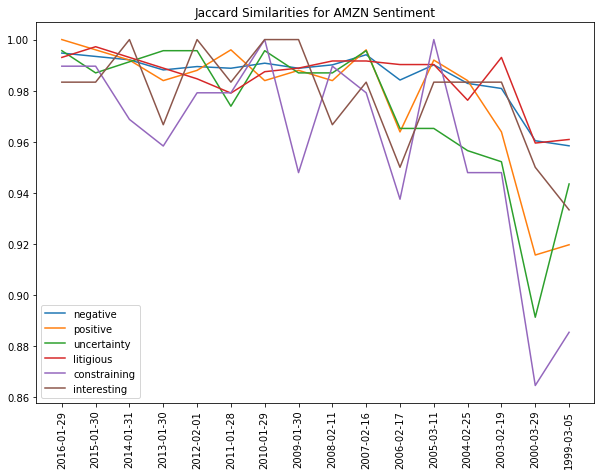

In [32]:
# Get dates for the universe
file_dates = {
    ticker: [ten_k['file_date'] for ten_k in ten_ks]
    for ticker, ten_ks in ten_ks_by_ticker.items()}  

jaccard_similarities = {
    ticker: {
        sentiment_name: get_jaccard_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_bow_ten_ks.items()}


plot_similarities(
    [jaccard_similarities[example_ticker][sentiment] for sentiment in sentiments],
    file_dates[example_ticker][1:],
    'Jaccard Similarities for {} Sentiment'.format(example_ticker),
    sentiments)

### TFIDF
using the sentiment word lists, let's generate sentiment TFIDF from the 10-k documents. Implement `get_tfidf` to generate TFIDF from each document, using sentiment words as the terms. You can ignore words that are not in `sentiment_words`.

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer


def get_tfidf(sentiment_words, docs):
    """
    Generate TFIDF values from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    
    # TODO: Implement
    
    vectorizer = TfidfVectorizer(vocabulary=sentiment_words.values)
    X = vectorizer.fit_transform(docs)    
    return X.toarray()



Using the `get_tfidf` function, let's generate the TFIDF values for all the documents.

In [34]:
sentiment_tfidf_ten_ks = {}

for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    
    sentiment_tfidf_ten_ks[ticker] = {
        sentiment: get_tfidf(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs)
        for sentiment in sentiments}

    
print_ten_k_data([sentiment_tfidf_ten_ks[example_ticker]], sentiments)

[
  {
    negative: '[[0.         0.         0.         ... 0.        ...
    positive: '[[0.22288432 0.         0.         ... 0.        ...
    uncertainty: '[[0.         0.         0.         ... 0.00510228...
    litigious: '[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0. 0....
    constraining: '[[0.         0.         0.         ... 0.        ...
    interesting: '[[0.01673784 0.         0.         ... 0.        ...},
]


### Cosine Similarity
Using the TFIDF values, we'll calculate the cosine similarity and plot it over time. Implement `get_cosine_similarity` to return the cosine similarities between each tick in time. Since the input, `tfidf_matrix`, is a TFIDF vector for each time period in order, you just need to computer the cosine similarities for each neighboring vector.

In [35]:
from sklearn.metrics.pairwise import cosine_similarity


def get_cosine_similarity(tfidf_matrix):
    """
    Get cosine similarities for each neighboring TFIDF vector/document

    Parameters
    ----------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.

    Returns
    -------
    cosine_similarities : list of float
        Cosine similarities for neighboring documents
    """
    
    # TODO: Implement
    
    cos_similarity= cosine_similarity(tfidf_matrix[0:], tfidf_matrix[1:])
    
    return cos_similarity[0].tolist()




Let's plot the cosine similarities over time.

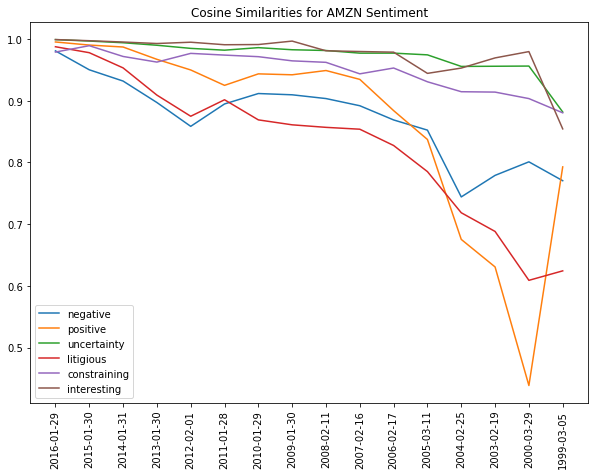

In [36]:
cosine_similarities = {
    ticker: {
        sentiment_name: get_cosine_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_tfidf_ten_ks.items()}


## Evaluate Alpha Factors
Just like we did in project 4, let's evaluate the alpha factors. For this section, we'll just be looking at the cosine similarities, but it can be applied to the jaccard similarities as well.
### Price Data
Let's get yearly pricing to run the factor against, since 10-Ks are produced annually.

pricing = pd.read_csv('../../data/project_5_yr/yr-quotemedia.csv', parse_dates=['date'])
pricing = pricing.pivot(index='date', columns='ticker', values='adj_close')


pricingplot_similarities(
    [cosine_similarities[example_ticker][sentiment] for sentiment in sentiments],
    file_dates[example_ticker][1:],
    'Cosine Similarities for {} Sentiment'.format(example_ticker),
    sentiments)